
Vergleich der Zufälligkeitseigenschaften:
                      Typ Anteil 1  Runs p-Wert  Binomial p-Wert  Chi2 p-Wert  Ljung-Box p  Lempel-Ziv  Muster p-Wert                             Bewertung
      Python Pseudozufall   0.4945      0.72787          0.27571      0.27133      0.56245     1.02315        0.63269 Mit hoher Wahrscheinlichkeit zufällig
Quantenzufall (simuliert)   0.4994      0.47159          0.91241      0.90448      0.24477     1.03511        0.90904 Mit hoher Wahrscheinlichkeit zufällig


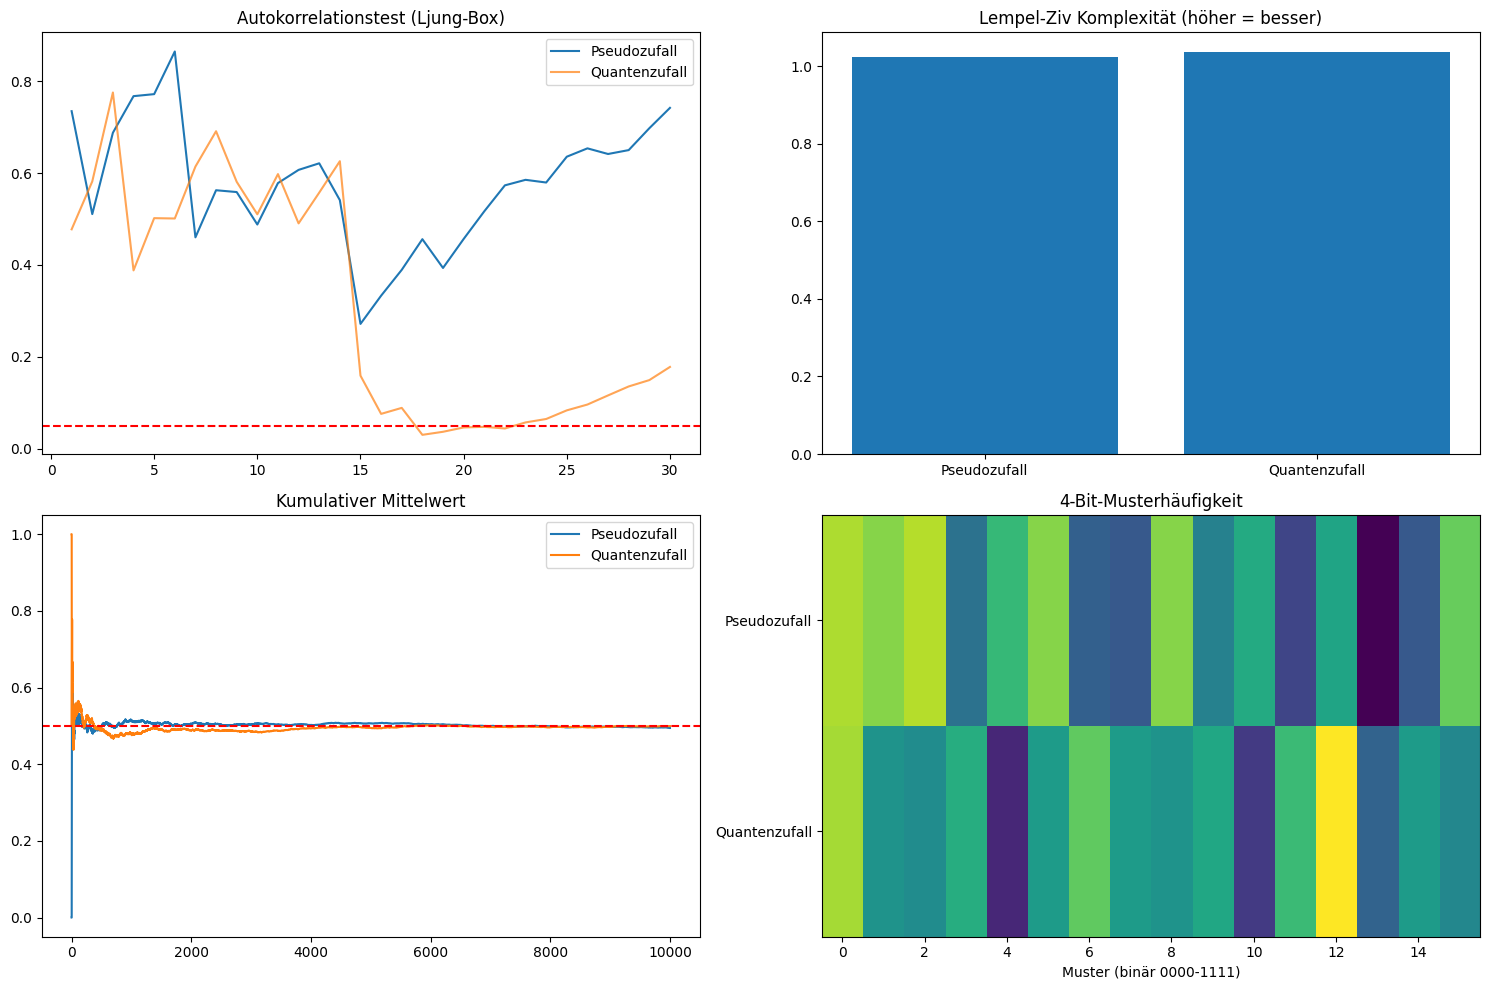

In [35]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
from collections import Counter

random.seed(1)
np.random.seed(1)
n = 10000

# Zufallsdaten erzeugen
pseudo_random = [random.randint(0, 1) for _ in range(n)]
quantum_random = np.random.randint(0, 2, n)  # Simulierter perfekter Zufall

def analyze_randomness(data, name):
    counts = Counter(data)
    prop = counts[1]/len(data)
    z_runs, p_runs = runstest_1samp(data, correction=False)
    p_binom = stats.binomtest(counts[1], n=len(data), p=0.5).pvalue
    _, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    lb = acorr_ljungbox(data, lags=[10, 20, 30], return_df=True)
    p_lb = lb['lb_pvalue'].mean()
    def lempel_ziv_complexity(binary_sequence):
        sequence = ''.join(map(str, binary_sequence))
        i, n, c = 0, len(sequence), 0
        while i < n:
            j = 1
            while i + j <= n and sequence[i:i+j] in sequence[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    lz = lempel_ziv_complexity(data)
    def pattern_test(sequence, pattern_length=4):
        patterns = [''.join(map(str, sequence[i:i+pattern_length])) 
                  for i in range(len(sequence)-pattern_length+1)]
        freq = Counter(patterns)
        return stats.chisquare(list(freq.values())).pvalue
    p_pattern = pattern_test(data)
    kritische_tests = {
        'Runs-Test': p_runs,
        'Binomialtest': p_binom,
        'Chi-Quadrat': p_chi2,
        'Ljung-Box': p_lb,
        'Muster-Test': p_pattern
    }
    auffaelligkeiten = [test for test, p in kritische_tests.items() if p < 0.05]
    if auffaelligkeiten:
        bewertung = f"NICHT zufällig (Auffälligkeiten in: {', '.join(auffaelligkeiten)})"
    else:
        bewertung = "Mit hoher Wahrscheinlichkeit zufällig"
    return {
        'Typ': name,
        'Anteil 1': f"{prop:.4f}",
        'Runs p-Wert': p_runs,
        'Binomial p-Wert': p_binom,
        'Chi2 p-Wert': p_chi2,
        'Ljung-Box p': p_lb,
        'Lempel-Ziv': lz,
        'Muster p-Wert': p_pattern,
        'Bewertung': bewertung
    }

results = [
    analyze_randomness(pseudo_random, "Python Pseudozufall"),
    analyze_randomness(quantum_random, "Quantenzufall (simuliert)")
]

results_df = pd.DataFrame(results)
print("\nVergleich der Zufälligkeitseigenschaften:")
print(results_df.to_string(index=False, float_format="%.5f"))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].plot(acorr_ljungbox(pseudo_random, lags=30, return_df=True)['lb_pvalue'], label='Pseudozufall')
axes[0,0].plot(acorr_ljungbox(quantum_random, lags=30, return_df=True)['lb_pvalue'], label='Quantenzufall', alpha=0.7)
axes[0,0].axhline(0.05, color='red', linestyle='--')
axes[0,0].set_title('Autokorrelationstest (Ljung-Box)')
axes[0,0].legend()

axes[0,1].bar(['Pseudozufall', 'Quantenzufall'], [results[0]['Lempel-Ziv'], results[1]['Lempel-Ziv']])
axes[0,1].set_title('Lempel-Ziv Komplexität (höher = besser)')

for data, label in zip([pseudo_random, quantum_random], ['Pseudozufall', 'Quantenzufall']):
    axes[1,0].plot(np.cumsum(data)/np.arange(1,n+1), label=label)
axes[1,0].axhline(0.5, color='red', linestyle='--')
axes[1,0].set_title('Kumulativer Mittelwert')
axes[1,0].legend()

pattern_counts = []
for data in [pseudo_random, quantum_random]:
    patterns = [''.join(map(str, data[i:i+4])) for i in range(len(data)-3)]
    counts = Counter(patterns)
    pattern_counts.append([counts.get(f"{i:04b}", 0) for i in range(16)])
axes[1,1].imshow(pattern_counts, cmap='viridis', aspect='auto')
axes[1,1].set_title('4-Bit-Musterhäufigkeit')
axes[1,1].set_yticks([0,1])
axes[1,1].set_yticklabels(['Pseudozufall', 'Quantenzufall'])
axes[1,1].set_xlabel('Muster (binär 0000-1111)')

plt.tight_layout()
plt.show()
